# Feature selection
 
Now we discuss the **feature selection** approach to dimensionality reduction. Feature selection approaches lower the dimensionality by picking a subset of original features. Typically, feature selection is done to facilitate predictions of a target variable in the context of supervised learning. The prediction problem we consider here is a two-class classification: given a gene expression profile, can we predict to which of the two tomato species it belongs? We will do a six-fold cross-validation of the prediction approach, keeping 4 data instances for testing while training on the other 20 instances. More specifically, we will do a leave-one-tissue-out cross-validation, training on the samples from five tissues and testing on the samples from the sixth tissue. In this way, we can evaluate whether the classification model based on selected features generalizes to unseen tissues. In total, we obtain six different models from this tissue-wise cross-validation.

We will consider examples for three types of feature selection approaches:
1. Filter methods
2. Wrapper methods
3. Embedded methods

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ReliefF import ReliefF
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

data_with_labels = pd.read_csv("../data/tomato_with_targets.txt", index_col=0)
labels = ['species','position','tissue','root']
data_original = data_with_labels.drop(columns = labels, axis = 1).to_numpy()
target = data_with_labels['species'].to_numpy()

## Filter methods 
Filter methods compute a score for each individual feature and rank the features according to the score. Then a prespecified number of top features is selected, or one takes all features that satisfy a prespecified threshold. Most filter methods are univariate and perform some statistical test with respect to the target variable. We will consider a multivariate filter method that uses k nearest neighbor computation across all the features to compute the score of an individual feature. The method is called ReliefF. Each feature obtains a score based on value differences between nearest neighbors. A value difference in nearest neighbors of the same class decreases the score, and a value difference in nearest neighbors of different classes increases the score. We determine the highest scoring feature on the training set and use it in a simple decision tree classifier.

Selected gene: 18967


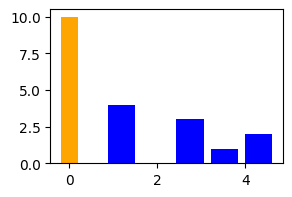

Test accuracy: 1.0
Selected gene: 20995


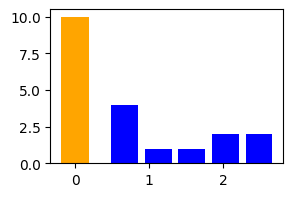

Test accuracy: 1.0
Selected gene: 26093


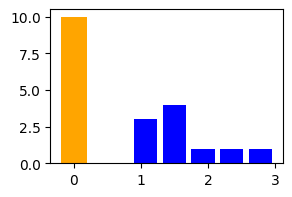

Test accuracy: 1.0
Selected gene: 11057


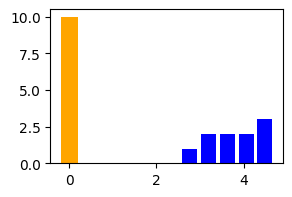

Test accuracy: 1.0
Selected gene: 6261


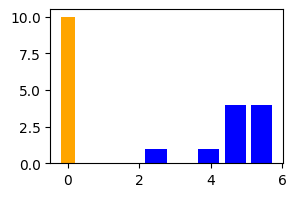

Test accuracy: 1.0
Selected gene: 11499


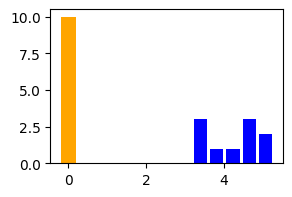

Test accuracy: 1.0


In [23]:
for tissue in data_with_labels['tissue'].unique():
    wtest = np.where(data_with_labels['tissue']==tissue)
    wtrain = np.setdiff1d(np.arange(0, data_with_labels.shape[0], 1), wtest)
    fs = ReliefF(n_neighbors=4, n_features_to_keep=1)
    X = fs.fit_transform(data_original[wtrain,:], target[wtrain])
    w = np.where(data_with_labels['species'].iloc[wtrain]=='M82')
    print(f"Selected gene: {fs.top_features[0]}")
    plt.rcParams["figure.figsize"] = (3,2) 
    plt.hist(X[w,0], bins=5, density=False, histtype='barstacked', rwidth=0.8, facecolor='blue')
    plt.hist(np.delete(X[:,0], w), bins=1, density=False, histtype='barstacked', rwidth=0.38, facecolor='orange')
    plt.show()
    classifier = tree.DecisionTreeClassifier()
    cl = classifier.fit(X, target[wtrain])
    accuracy = accuracy_score(target[wtest], cl.predict(data_original[wtest, fs.top_features[0]].reshape(-1, 1)))
    print(f"Test accuracy: {accuracy}")

In each cross-validation iteration, a different gene got selected as the top feature, but the gene-based species classification always generalized well to the unseen tissue, as reflected by the perfect accuracy.

## Wrapper methods

Wrapper methods do not depend on the machine learning approach used for modeling. In other words, the same wrapper can be used for many different machine learning approaches. They perform a search through possible sets of features. For each considered combination of features, a model is trained and evaluated on a validation set. The evaluation scores are used to select the best among candidate sets. Forward selection is a greedy procedure starting with an empty feature set and adding in each step the feature leading to the set with the best performance on validation data. To have validation data that are independent from the data used for training the model, typically a nested cross-validation on the training data is performed, just like for the hyperparameter optimization in general machine learning approaches. The test set is reserved for final evaluation of the model with selected features and is not touched during the feature selection. The following graphic illustrates the analysis that is done for a single step in the forward selection.

<center><img src="./figures/wrapper.png" width="500"/></center>


We will try the forward selection approach using a random forest model.

### Task
1. Backward elimination is another wrapper approach. It starts from all features and progressively eliminates the least promising ones. Please consider advantages and disadvantages of this approach.
2. How can you adjust the approach to alleviate the disadvantages?

## Embedded methods 

Embedded methods learn which features are important while the model is built. These methods use regularization to drive the optimization toward models of lower complexity. As an example method from this category, we will apply elastic net regression, which is very useful in practice for high-dimensional data. It is a linear modeling approach where the objective function contains a combination of L1 and L2 regularization. The L1 regularization favors sparse solutions, setting many coefficients to zero and thus performing feature selection. The L2 regularization shrinks the coefficients of correlated predictors towards each other, such that either all correlated features are selected or none of them. We again perform cross-validation via a tissue-wise split. We set the L1-L2 tradeoff parameter to 0.5 and the C-value via the Ledoit-Wolf method. We show the number of selected genes for each model from the cross-validation as well as the number of genes that were selected in all models (i.e., the overall intersection).